In [2]:
import keras
import numpy as np
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from sklearn.model_selection import train_test_split 
from sklearn.utils.linear_assignment_ import linear_assignment
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn import metrics
import mnist_reader
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

In [4]:
#import data set 
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')
X_train1=(np.reshape(X_train,(-1,28,28,1)))/255
X_test1=(np.reshape(X_test,(-1,28,28,1)))/255
train_set,val_set,train_out,val_out = train_test_split(X_train1,X_train1,test_size=0.2,random_state=12)

In [5]:
#linear assignment cost function 
def cost(cm):
    return (- cm + np.max(cm))

In [6]:
#reordering confusion matrix for clustering using linear assignment 
def conf_mat(cm):

    indexes = linear_assignment(cost(cm))
    js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
    cm2 = cm[:, js]
    return cm2

In [6]:
#determining the number of clusters using elbow method 
inertias=[]
for i in range(2,13): 
    #Building and fitting the model 
    kmeanbasis= KMeans(n_clusters=i).fit(X_train)       
    inertias.append(kmeanbasis.inertia_) 

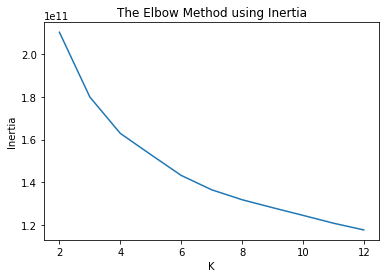

In [10]:
#elbow graph
plt.plot(range(2,13), inertias) 
plt.xlabel('K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 


In [45]:
#Fit K-Means Basis with the Train data 
kmeanbasis.n_clusters =10
kmeanbasis.fit(X_train1.reshape(X_train1.shape[0],-1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [46]:
#confusion matrix for K-Means Basis 
y_kb = kmeanbasis.predict(X_test1.reshape(X_test1.shape[0],-1))
cm_kb= metrics.confusion_matrix(y_test, y_kb)
cm_kb2= conf_mat(cm_kb)

In [55]:
print(cm_kb2)

[[587  29   6   0  34  94 244   1   5   0]
 [ 50 890   0   0   9  22  29   0   0   0]
 [ 19   4   4   0 566  61 342   0   4   0]
 [277 503   2   0  10  94 111   0   3   0]
 [136  27   4   0 627  42 159   0   5   0]
 [  0   0   0  45   0 650   6 227   0  72]
 [189  12  15   0 311 116 357   0   0   0]
 [  0   0   0   2   0  62   0 784   0 152]
 [  3   6 353   1  61  84  35  39 408  10]
 [  0   0   0 423   0  29   4  23   2 519]]


In [16]:
#Architecture of auto encoder 
autoencoder = Sequential()
autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same',name="output"))

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(16, (3, 3), activation='relu'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

In [17]:
#auto encoder compilation 
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [18]:
#training 
autoencoder_train = autoencoder.fit(train_set, train_out, batch_size=64,epochs=100,verbose=1,validation_data=(val_set, val_out))

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 23s 475us/step - loss: 0.0359 - val_loss: 0.0254
Epoch 2/100
48000/48000 [==============================] - 6s 118us/step - loss: 0.0246 - val_loss: 0.0242
Epoch 3/100
48000/48000 [==============================] - 6s 118us/step - loss: 0.0222 - val_loss: 0.0216
Epoch 4/100
48000/48000 [==============================] - 6s 118us/step - loss: 0.0207 - val_loss: 0.0195
Epoch 5/100
48000/48000 [==============================] - 6s 118us/step - loss: 0.0197 - val_loss: 0.0185
Epoch 6/100
48000/48000 [==============================] - 6s 119us/step - loss: 0.0188 - val_loss: 0.0180
Epoch 7/100
48000/48000 [==============================] - 6s 118us/step - loss: 0.0182 - val_loss: 0.0198
Epoch 8/100
48000/48000 [==============================] - 6s 119us/step - loss: 0.0177 - val_loss: 0.0177
Epoch 9/100
48000/48000 [==============================] - 6s 119us/step - loss: 0.0172 - val

In [19]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
output (MaxPooling2D)        (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 8)           584       
__________

In [20]:
#building the encoder from the auto encoder
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('output').output)

In [31]:
#Kmeans classification with the condensed data 
kmeans=KMeans( n_clusters = 10).fit(encoder.predict(X_train1).reshape(X_train1.shape[0],-1))

In [32]:
#prediction of encoded data 
encoded= encoder.predict(X_test1)

In [33]:
print(encoded.shape)

(10000, 4, 4, 8)


In [34]:
#prediction of encoded clusters using kmeans 
y_pred = kmeans.predict(encoded.reshape(X_test1.shape[0],-1))

In [35]:
print(y_pred.shape)

(10000,)


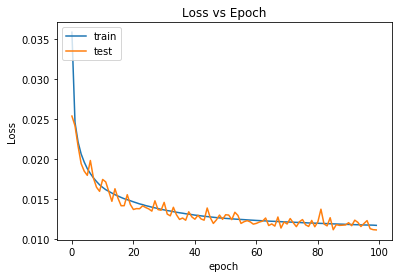

In [54]:
#auto encoder loss vs epochs graph
import matplotlib.pyplot as plt
plt.plot(autoencoder.history.history['loss'])
plt.plot(autoencoder.history.history['val_loss'])
plt.title("Loss vs Epoch")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [49]:
#confusion matrix for autoencoder based kmeans classification
cm_k= metrics.confusion_matrix(y_test, y_pred)

In [50]:
cm_k2= conf_mat(cm_k)
print(cm_k2)

[[433  30 237   2  41   3 249   2   3   0]
 [ 32 776  25   0   6   0 161   0   0   0]
 [ 18   4 323   3 427   1 221   0   3   0]
 [260 412  68   1   5   0 252   0   2   0]
 [123  24 266   2 477   0 103   0   5   0]
 [  0   0   6   3   0 720  29 134   1 107]
 [126  20 306  12 233   7 294   1   1   0]
 [  0   0   0   2   0 284   0 699   0  15]
 [  1   4  39 305  56  57  83  57 398   0]
 [  4   1   5   2   7  53   2 204   0 722]]


In [52]:
#Gmm model initialization 
gmm = GaussianMixture(n_components=10, covariance_type='full', init_params='kmeans',   random_state=12 )

In [53]:
#GMM model fitting 
gmm.fit((encoder.predict(X_train1)).reshape(X_train1.shape[0],-1))

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=10, n_init=1, precisions_init=None,
        random_state=12, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [56]:
#GMM model prediction 
y_gmm= gmm.predict(encoded.reshape(X_test1.shape[0],-1))

In [57]:
y_gmm

array([6, 5, 4, ..., 0, 4, 6], dtype=int64)

In [58]:
print(metrics.normalized_mutual_info_score(y_test,y_gmm))

0.5633530549589136


In [59]:
#confusion matrix for GMM Clustering 
cm_g= metrics.confusion_matrix(y_test, y_gmm)

In [60]:
cm_g2 = conf_mat(cm_g)

In [64]:
print(cm_g2)

[[674   7  40 128   9   0  93   0  49   0]
 [  0 862  16 104   1   0  12   0   5   0]
 [  7   0  56  50 735   0  48   0 104   0]
 [ 10 228 136 577  10   0  23   0  16   0]
 [  0   0  23 195 709   0  41   0  32   0]
 [  0   0   0   0   0 230  81 359   3 327]
 [167   2  50 144 442   0  74   0 121   0]
 [  0   0   0   0   0 306   1 671   1  21]
 [  0   0  93   3   1   2  42   2 857   0]
 [  0   0   0   0   0 278  19  10   0 693]]


In [62]:
#Accuracy for The THREE MODELS 
kmeans_acc=(np.trace(cm_k2)/np.sum(cm_k2))
kmeansbasis_acc=(np.trace(cm_kb2)/np.sum(cm_kb2))
gmm_acc=(np.trace(cm_g2)/np.sum(cm_g2))

In [63]:
print("K Means Basis Accuracy:", kmeansbasis_acc*100 )
print("K Means Accuracy:", kmeans_acc*100 )
print("GMM Accuracy:", gmm_acc*100 )

K Means Basis Accuracy: 48.26
K Means Accuracy: 48.43
GMM Accuracy: 54.03
